In [32]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from varseek.utils import calculate_metrics, create_stratified_metric_bar_plot_updated, create_venn_diagram, draw_confusion_matrix, plot_overall_metrics, create_stratified_metric_line_plot, create_benchmarking_legend, print_json, plot_frequency_histogram, find_specific_value_from_metric_text_file, color_map_20

In [2]:
tools = ["varseek", "gatk_mutect2", "gatk_haplotypecaller"]  # Ensure that any additional tools have columns DP_{tool} (int ≥ 0) AND/OR mutation_detected_{tool} (bool) in {simulated_data_output_dir}/unique_mcrs_df.csv for each tool TOOL
simulated_data_output_dir = '/home/jrich/data/varseek_data_fresh/manuscript_worthy/vk_sim_2024dec17_complex_testing'  # make sure this matches notebook 2
gatk_output_dir = "/home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing"  # make sure this matches 2_2
fig2_output_dir = '/home/jrich/data/varseek_data_fresh/manuscript_worthy/fig2_output_dec17'
run_setup_notebooks = False
download_files = False

In [ ]:
unique_mcrs_df_path = os.path.join(simulated_data_output_dir, 'unique_mcrs_df_with_gatk.csv')
# read_df_path = os.path.join(simulated_data_output_dir, 'synthetic_reads_updated.csv')
gatk_mutect2_reference_stats = f"{gatk_output_dir}/reference_metrics_mutect2.txt"
gatk_haplotypecaller_reference_stats = f"{gatk_output_dir}/reference_metrics_haplotypecaller.txt"

if download_files:
    #!! download the above files in the specified paths
    
    
    run_setup_notebooks = False

In [ ]:
# import importlib
# import varseek.utils.visualization_utils
# importlib.reload(varseek.utils.visualization_utils)
# from varseek.utils.visualization_utils import create_stratified_metric_bar_plot_updated

# Make sure to change parameters and paths appropriately in 1_1, 2, and 2_2

# Make vk index if not created already - run notebook 1_1

In [4]:
if run_setup_notebooks and not os.path.exists("1_1_variant_detection_reference_building_fig2.ipynb"):
    run_index_creation_command = "jupyter nbconvert --to notebook --execute --output 1_1_variant_detection_reference_building_fig2.ipynb 1_1_variant_detection_reference_building.ipynb"
    subprocess.run(run_index_creation_command, shell=True)

# Create simulated data with vk sim and run variant screening with vk - 2

In [5]:
if run_setup_notebooks and not os.path.exists("2_variant_simulation_fig2.ipynb"):
    run_simulated_data_creation_and_vk_screening_command = "jupyter nbconvert --to notebook --execute --output 2_variant_simulation_fig2.ipynb 2_variant_simulation.ipynb"
    subprocess.run(run_simulated_data_creation_and_vk_screening_command, shell=True)

# Run variant calling with GATK (haplotypecaller and mutect2)

In [6]:
if run_setup_notebooks and not os.path.exists("2_2_gatk_workflow.ipynb"):
    run_simulated_data_creation_and_vk_screening_command = "jupyter nbconvert --to notebook --execute --output 2_2_gatk_workflow_fig2.ipynb 2_2_gatk_workflow.ipynb"
    subprocess.run(run_simulated_data_creation_and_vk_screening_command, shell=True)

# Generate plots for Fig 2

In [3]:
os.makedirs(fig2_output_dir, exist_ok=True)

unique_mcrs_df = pd.read_csv(unique_mcrs_df_path)
# read_df = pd.read_csv(read_df_path)

fp_including_noncosmic_dict = {}
fp_including_noncosmic_dict['gatk_mutect2'] = find_specific_value_from_metric_text_file(gatk_mutect2_reference_stats, line = "FP including non-cosmic:")
fp_including_noncosmic_dict['gatk_haplotypecaller'] = find_specific_value_from_metric_text_file(gatk_haplotypecaller_reference_stats, line = "FP including non-cosmic:")

/tmp/ipykernel_69545/3552281294.py:4: DtypeWarning: Columns (36,38) have mixed types. Specify dtype option on import or set low_memory=False.
  unique_mcrs_df = pd.read_csv(unique_mcrs_df_path)


In [8]:
# Ensure that any additional tools have columns DP_{tool} (int ≥ 0) in {simulated_data_output_dir}/unique_mcrs_df.csv for each tool TOOL
if 'included_in_synthetic_reads_mutant' not in unique_mcrs_df.columns:
    unique_mcrs_df['included_in_synthetic_reads_mutant'] = unique_mcrs_df['number_of_reads_mutant'] > 0

for tool in tools:
    assert f'DP_{tool}' in unique_mcrs_df.columns or f'mutation_detected_{tool}' in unique_mcrs_df.columns, f"DP_{tool} or mutation_detected_{tool} must be in unique_mcrs_df.columns"
    if f'mutation_detected_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'mutation_detected_{tool}'] = unique_mcrs_df[f'DP_{tool}'] > 0
    if f'TP_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'TP_{tool}'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'TN_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'TN_{tool}'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'FP_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'FP_{tool}'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'FN_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'FN_{tool}'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'mutation_expression_prediction_error_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'mutation_expression_prediction_error_{tool}'] = unique_mcrs_df[f'DP_{tool}'] - unique_mcrs_df['number_of_reads_mutant']

varseek
TP: 380274, FP: 12866, FN: 1005, TN: 4857516
Accuracy: 0.9973587404061306, Sensitivity: 0.9973641349248188, Specificity: 0.9973583180949667
Mean Expression Error: -0.5050363738108562, Median Expression Error: 0.0, Mean Magnitude Expression Error: 0.5795645317189805, Median Magnitude Expression Error: 0.0


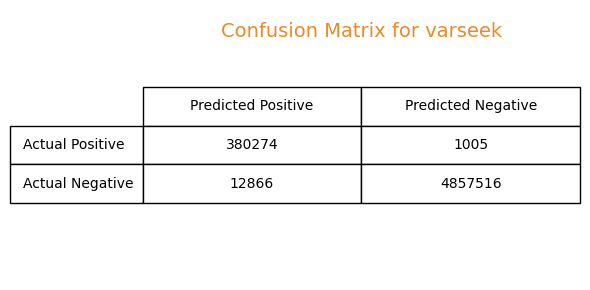

-------------------------------------------------------------------------------------------------------------------------------------------------------
gatk_mutect2
TP: 205299, FP: 1549, FN: 175980, TN: 4868833
Accuracy: 0.9661956474342117, Sensitivity: 0.5384482229548441, Specificity: 0.9996819551320615
Mean Expression Error: 147.54681310943107, Median Expression Error: 63.0, Mean Magnitude Expression Error: 160.81989691629093, Median Magnitude Expression Error: 72.0


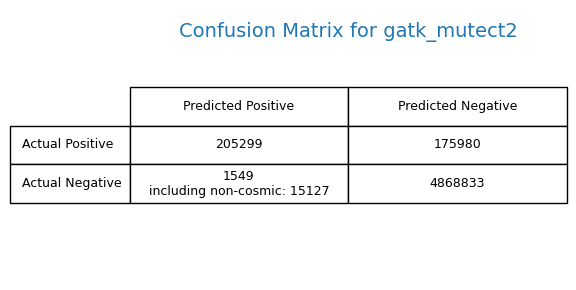

-------------------------------------------------------------------------------------------------------------------------------------------------------
gatk_haplotypecaller
TP: 130490, FP: 3341, FN: 250789, TN: 4867041
Accuracy: 0.9516095955165423, Sensitivity: 0.3422428195625775, Specificity: 0.9993140168471385
Mean Expression Error: 83.51149156430145, Median Expression Error: 31.0, Mean Magnitude Expression Error: 103.2407795853077, Median Magnitude Expression Error: 43.0


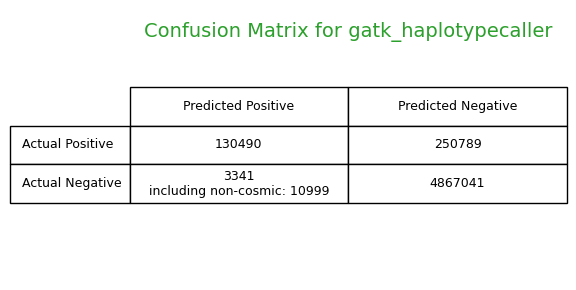

-------------------------------------------------------------------------------------------------------------------------------------------------------


In [36]:
metric_dict_collection = OrderedDict()
for index, tool in enumerate(tools):
    print(tool)
    metric_dict_collection[tool] = calculate_metrics(unique_mcrs_df, header_name = "mcrs_header", suffix=f"_{tool}", out = f"{fig2_output_dir}/reference_metrics_{tool}.txt")
    if tool in fp_including_noncosmic_dict:
        metric_dict_collection[tool]["FP including non-cosmic"] = fp_including_noncosmic_dict[tool]
    draw_confusion_matrix(metric_dict_collection[tool], title = f"Confusion Matrix for {tool}", title_color = color_map_20[index], additional_fp_key = "FP including non-cosmic", output_file=f"{fig2_output_dir}/confusion_matrix_{tool}.pdf")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")

# Create legend

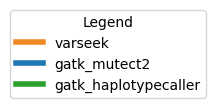

In [8]:
create_benchmarking_legend(tools, f"{fig2_output_dir}/legend.pdf")

# Bar plot of various metrics

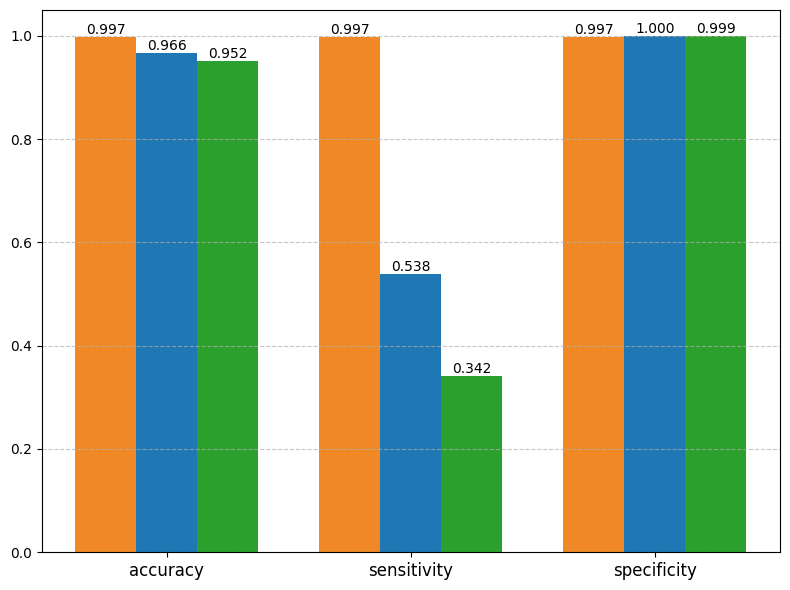

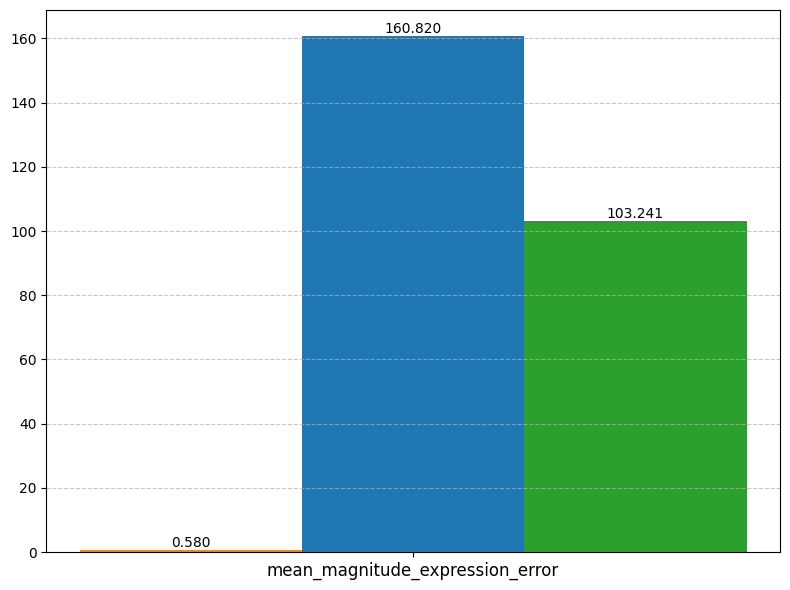

In [10]:
# plot_overall_metrics(metric_dict_collection, primary_metrics = ["accuracy", "sensitivity", "specificity"], secondary_metric = "mean_magnitude_expression_error", display_numbers=True, output_file = f"{fig2_output_dir}/overall_metrics.pdf")
plot_overall_metrics(metric_dict_collection, primary_metrics = ["accuracy", "sensitivity", "specificity"], display_numbers=True, show_p_values = False, unique_mcrs_df = unique_mcrs_df, output_file = f"{fig2_output_dir}/overall_metrics_acc_sens_spec.pdf", output_file_p_values = f"{fig2_output_dir}/overall_metrics_acc_sens_spec_p_values.json", bonferroni=True)  # to plot in separate plots
# print_json(f"{fig2_output_dir}/overall_metrics_acc_sens_spec_p_values.json")

plot_overall_metrics(metric_dict_collection, primary_metrics = "mean_magnitude_expression_error", display_numbers=True, show_p_values = False, unique_mcrs_df = unique_mcrs_df, output_file = f"{fig2_output_dir}/overall_metrics_error.pdf", output_file_p_values = f"{fig2_output_dir}/overall_metrics_expression_error_p_values.json", bonferroni=True, filter_real_negatives = True)  # to plot in separate plots
# print_json(f"{fig2_output_dir}/overall_metrics_expression_error_p_values.json")

# Number of detected reads for false positives

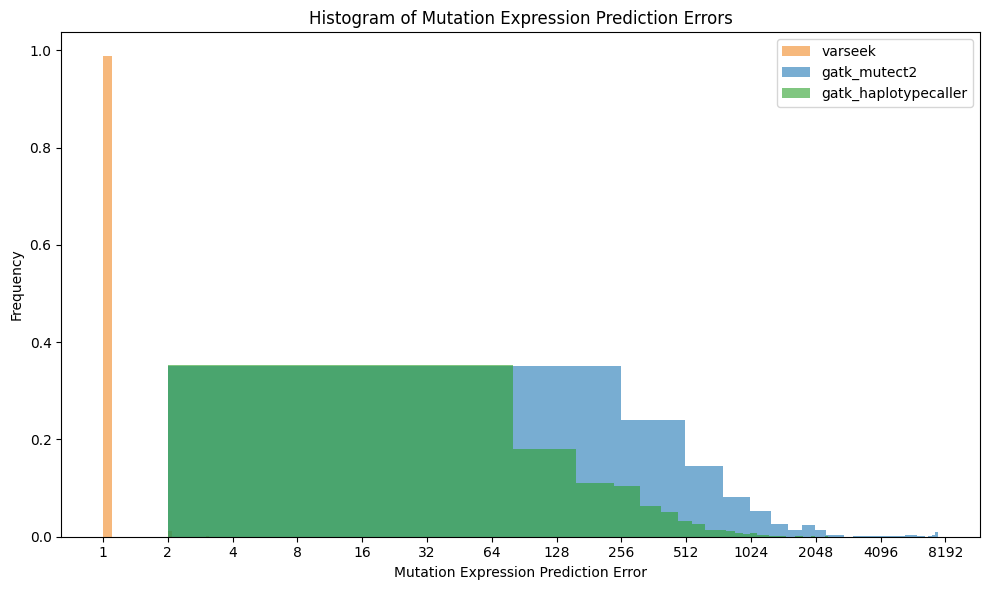

In [45]:
plot_frequency_histogram(unique_mcrs_df, 'DP', tools, fraction=True, output_file = f"{fig2_output_dir}/DP_histogram.pdf")

# Stratified metric line plot of all 3 methods: sensitivity vs mutant read depth

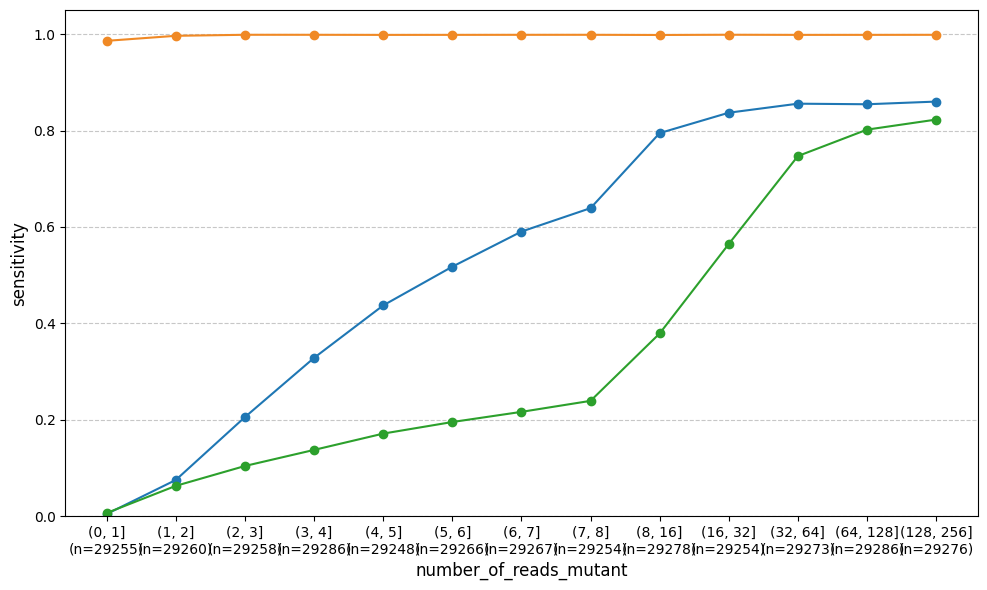

In [17]:
x_stratification = "number_of_reads_mutant"
y_metric = "sensitivity"
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, float('inf')]  # start at 1 because 0 values are automatically removed with y_metric = "sensitivity"
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf", output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt", filter_real_negatives = True)

# Stratified metric line plot of all 3 methods: sensitivity vs tumor purity

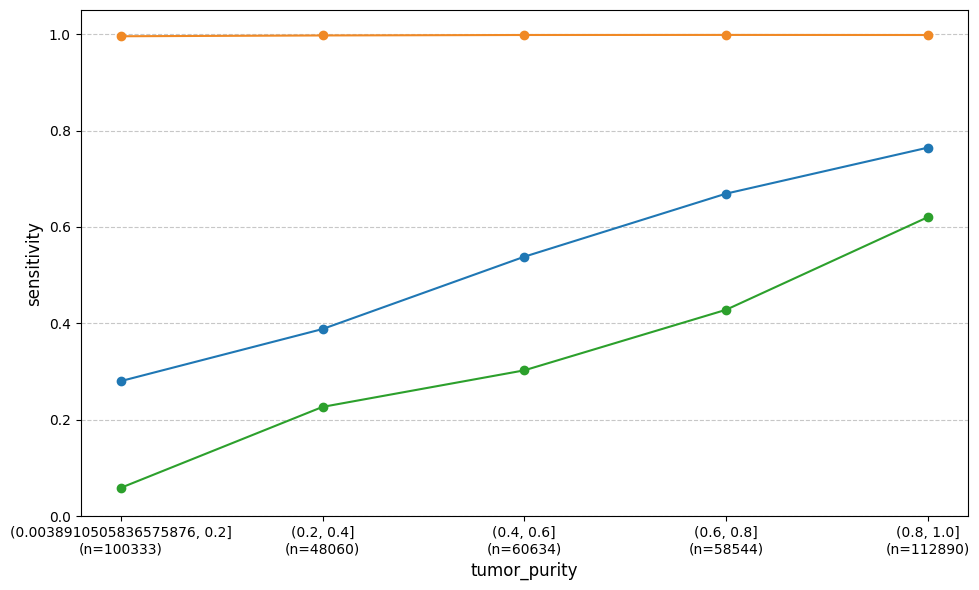

In [25]:
x_stratification = "tumor_purity"
y_metric = "sensitivity"
bins = [-float('inf'), 0.2, 0.4, 0.6, 0.8, float('inf')]  # bins = None  # bins = [0, 0.25, 0.5, 0.75, 1]  # [-float('inf'), 0.25, 0.5, 0.75, float('inf')]  # absolute lower bound, midpoint1, midpoint2, ..., absolute upper bound - eg bins [0, 0.25, 0.5, 0.75, 1] --> labels ["(0, 0.25]", "(0.25, 0.5]", "(0.5, 0.75]", "(0.75, 1]"] - if absolute lower bound provided is less than real absolute lower bound, then just use -float(inf) and it is replaced internally (and same for upper)
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf", output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt")

# Stratified metric line plot of all 3 methods: mean_magnitude_expression_error vs mutant sequencing depth

JMR0
JMR0.25
JMR0.5
JMR1
JMR2
JMR3
JMR4
JMR5


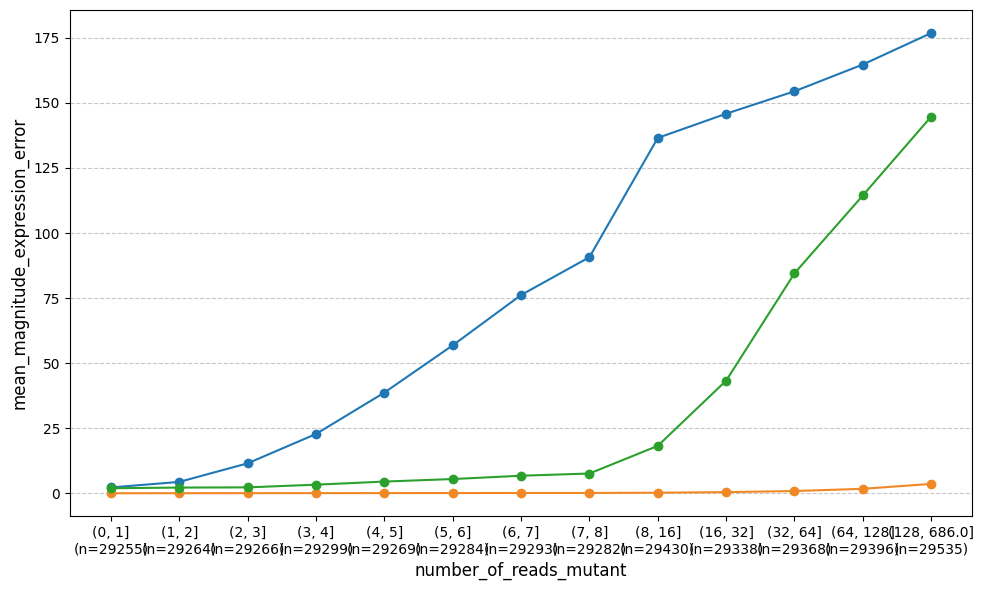

In [13]:
x_stratification = "number_of_reads_mutant"
y_metric = "mean_magnitude_expression_error"  # mean_magnitude_expression_error or mean_expression_error
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, float('inf')]
filter_real_negatives = False  # set this to True when y_metric is expression error for all cases besides x_stratification = "number_of_reads_mutant", as we are not interested in the vast majority of cases that are real 0 and predicted 0
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins=bins, filter_real_negatives = filter_real_negatives, show_p_values = False, show_confidence_intervals = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf", output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt")

# Stratified metric bar plot of all 3 methods: sensitivity vs mutation type

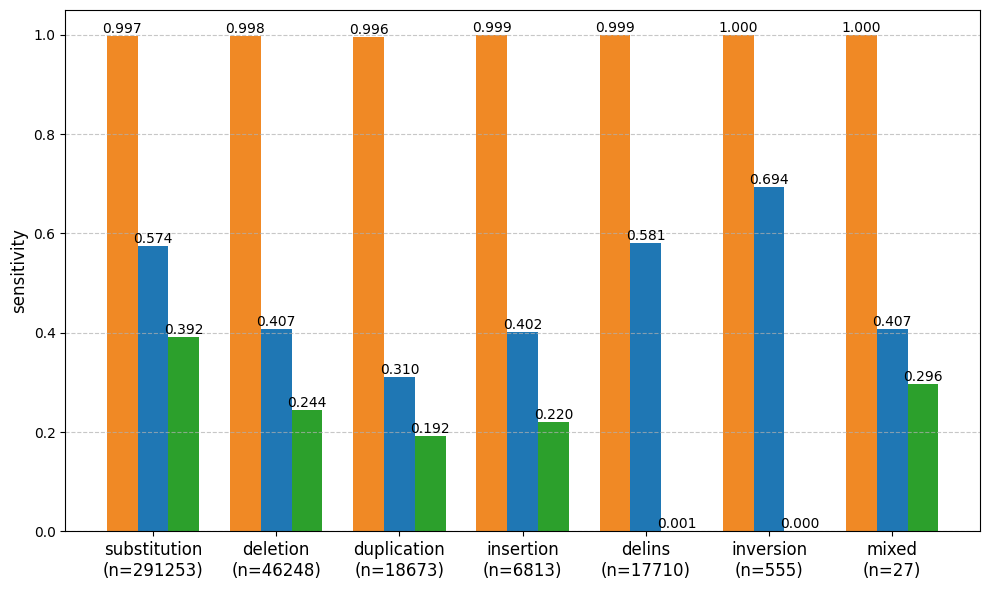

In [67]:
x_stratification = "mcrs_mutation_type"
y_metric = "sensitivity"
create_stratified_metric_bar_plot_updated(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, display_numbers = True, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf", output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt")

# Stratified metric bar plot of all 3 methods: mean mutation expression error vs mutation type

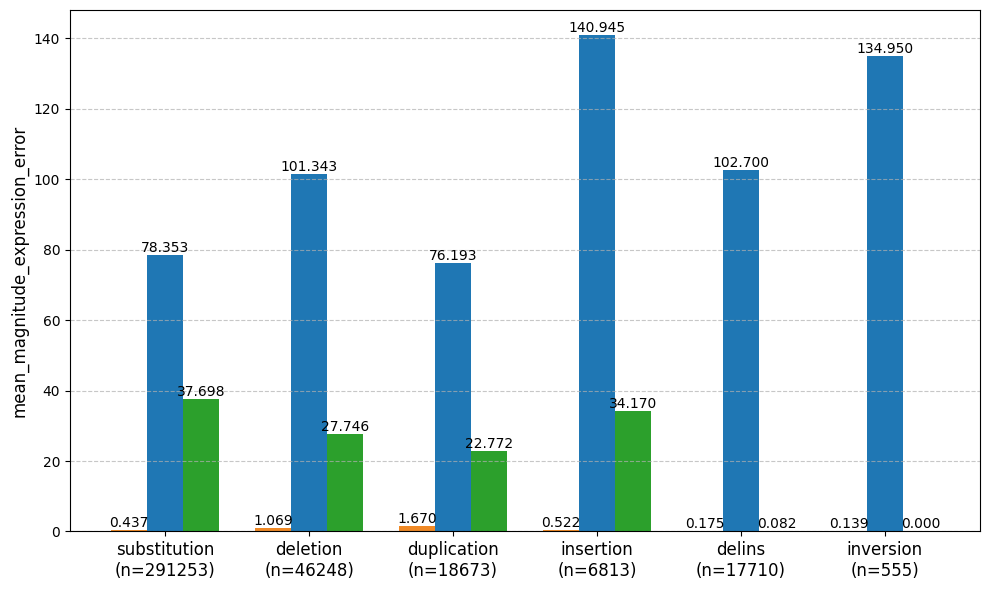

In [18]:
x_stratification = "mcrs_mutation_type"
y_metric = "mean_magnitude_expression_error"  # mean_magnitude_expression_error or mean_expression_error
filter_real_negatives = True
create_stratified_metric_bar_plot_updated(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, display_numbers = True, show_p_values = False, filter_real_negatives = filter_real_negatives, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf", output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt")